In [1]:
import numpy as np
import os

class KMNISTDataLoader(object):
    """
    Example
    -------
    >>> kmnist_dl = KMNISTDataLoader()
    >>> datapath = "./data"
    >>> train_imgs, train_lbls, validation_imgs, validation_lbls = kmnist_dl.load(datapath)
    """
    def __init__(self, validation_size: float):
        """
        validation_size : float
        [0., 1.]
        ratio of validation data
        """
        self._basename_list = [
        'kmnist-train-imgs.npz',\
        'kmnist-train-labels.npz'
        ]
        self.validation_size = validation_size

    def load(self, datapath: str, random_seed: int=13) -> np.ndarray:
        filenames_list = self._make_filenames(datapath)
        data_list = [np.load(filename)['arr_0'] for filename in filenames_list]

        all_imgs, all_lbls = data_list

        # shuffle data
        np.random.seed(random_seed)
        perm_idx = np.random.permutation(len(all_imgs))
        all_imgs = all_imgs[perm_idx]
        all_lbls = all_lbls[perm_idx]

        # split train and validation
        validation_num = int(len(all_lbls)*self.validation_size)

        validation_imgs = all_imgs[:validation_num]
        validation_lbls = all_lbls[:validation_num]

        train_imgs = all_imgs[validation_num:]
        train_lbls = all_lbls[validation_num:]

        return train_imgs, train_lbls, validation_imgs, validation_lbls

    def _make_filenames(self, datapath: str) -> list:
        filenames_list = [os.path.join(datapath, basename) for basename in self._basename_list]
        return filenames_list

In [2]:
datapath = "competition_images"
validation_size = 0.2
train_imgs, train_lbls, validation_imgs, validation_lbls = KMNISTDataLoader(validation_size).load(datapath)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class RandomPlotter(object):
    def __init__(self):
        self.label_char = ["お(o)", "き(ki)", "す(su)", "つ(tsu)",\
                           "な(na)", "は(ha)", "ま(ma)", "や(ya)",\
                           "れ(re)", "を(wo)"]
        plt.rcParams['font.family'] = 'IPAPGothic'

    def _get_unique_labels(self, labels: np.ndarray) -> np.ndarray:
        label_unique = np.sort(np.unique(labels))
        return label_unique

    def _get_random_idx_list(self, labels: np.ndarray) -> list:
        label_unique = self._get_unique_labels(labels)

        random_idx_list = []
        for label in label_unique:
            label_indices = np.where(labels == label)[0]
            random_idx = np.random.choice(label_indices)
            random_idx_list.append(random_idx)

        return random_idx_list

    def plot(self, images: np.ndarray, labels: np.ndarray) -> None:
        """
        Parameters
        ----------
        images : np.ndarray
        train_imgs or validation_imgs

        labels : np.ndarray
        train_lbls or validation_lbls
        """
        random_idx_list = self._get_random_idx_list(labels)

        fig = plt.figure()
        for i, idx in enumerate(random_idx_list):
            ax = fig.add_subplot(2, 5, i+1)
            ax.tick_params(labelbottom=False, bottom=False)
            ax.tick_params(labelleft=False, left=False)
            img = images[idx]
            ax.imshow(img, cmap='gray')
            ax.set_title(self.label_char[i])
        fig.show()

<ipython-input-3-d8bb5857cb04>:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
/Users/hagiwararyo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12362 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/hagiwararyo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12365 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/hagiwararyo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12377 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/hagiwararyo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12388 missing from current font.
 

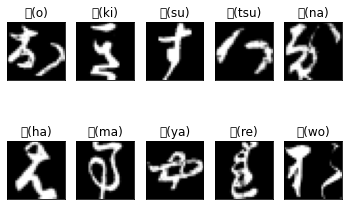

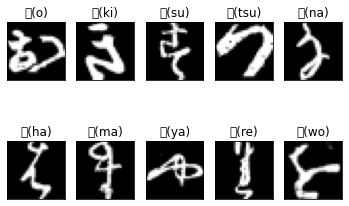

In [4]:
RandomPlotter().plot(train_imgs, train_lbls)
RandomPlotter().plot(validation_imgs, validation_lbls)

In [5]:
print(train_imgs.shape,train_lbls)

(48000, 28, 28) [6 7 8 ... 5 1 9]


In [9]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

In [10]:
# データ前処理
x_train = train_imgs.reshape(train_imgs.shape[0], 28, 28, 1)
x_test = validation_imgs.reshape(validation_imgs.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [11]:
y_train = to_categorical(train_lbls, 10)
y_test = to_categorical(validation_lbls, 10)

In [12]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same',
          input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))               
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))                
model.add(Dropout(0.5))                                   
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))                                 
model.add(Dense(10, activation='softmax'))

In [13]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=['accuracy'])

In [15]:
history = model.ﬁt(x_train, y_train, batch_size=1024, epochs=20,verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
47/47 [==============================] - 45s 760ms/step - loss: 1.3301 - accuracy: 0.5463 - val_loss: 0.2650 - val_accuracy: 0.9219
Epoch 2/20
47/47 [==============================] - 35s 737ms/step - loss: 0.2811 - accuracy: 0.9146 - val_loss: 0.1423 - val_accuracy: 0.9574
Epoch 3/20
47/47 [==============================] - 35s 742ms/step - loss: 0.1703 - accuracy: 0.9484 - val_loss: 0.1008 - val_accuracy: 0.9702
Epoch 4/20
47/47 [==============================] - 35s 747ms/step - loss: 0.1238 - accuracy: 0.9620 - val_loss: 0.0814 - val_accuracy: 0.9756
Epoch 5/20
47/47 [==============================] - 37s 779ms/step - loss: 0.0978 - accuracy: 0.9692 - val_loss: 0.0718 - val_accuracy: 0.9780
Epoch 6/20
47/47 [==============================] - 36s 771ms/step - loss: 0.0813 - accuracy: 0.9750 - val_loss: 0.0660 - val_accuracy: 0.9807
Epoch 7/20
47/47 [==============================] - 36s 766ms/step - loss: 0.0682 - accuracy: 0.9784 - val_loss: 0.0587 - val_accuracy: 0.9825

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04499480873346329
Test accuracy: 0.9884999990463257


In [18]:
import numpy as np

test = np.load("competition_images/kmnist-test-imgs.npz")

In [22]:
x_pred = test["arr_0"].reshape(test["arr_0"].shape[0], 28, 28, 1)

In [23]:
result = model.predict(x_pred)

In [24]:
result

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [28]:
decoded_result = np.argmax(result, axis=1)

In [27]:
import pandas as pd
submit_df = pd.DataFrame({'Label': decoded_result})
submit_df.index.name = 'ImageId'
submit_df.to_csv('drive/MyDrive/data/submission.csv')

array([2, 9, 3, ..., 9, 4, 2])